# TMDB Box Office Prediction Project (Youssef Ben Fadhel)

## 1) Exploratory Data Analysis (EDA)

### Imports and file management

In [5]:
path_data = ""
import zipfile
with zipfile.ZipFile(path_data+"tmdb-box-office-prediction.zip","r") as f:
       f.extractall('files',members = ["sample_submission.csv", "test.csv", "train.csv"])

In [6]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [10]:
train = pd.read_csv(path_data + 'train.csv')
y = train["revenue"]
test = pd.read_csv(path_data + 'test.csv')
test_ids = test["id"]
n_train = train.shape[0]
n_test = test.shape[0]

### Getting rid of a few selected variables

In [11]:
train.drop(columns=["belongs_to_collection","id", "imdb_id", "poster_path", "original_title", "title", "overview"], inplace=True)
test.drop(columns=["belongs_to_collection", "id", "imdb_id", "poster_path", "original_title", "title", "overview"], inplace=True)
print(train["status"].value_counts())
train.drop(columns="status", inplace=True)
test.drop(columns="status", inplace=True)

Released    2996
Rumored        4
Name: status, dtype: int64


### Investigating missing data

In [12]:
percentage_NA = [100*train.isnull().sum()/n_test, 100*train.isnull().sum()/n_test]
percentage_NA = pd.concat(percentage_NA, axis = 1, keys = ["Missing in train (%)",
                                                 "Missing in test (%)"])
print(percentage_NA[percentage_NA["Missing in train (%)"] > 10])

          Missing in train (%)  Missing in test (%)
homepage             46.703047            46.703047
tagline              13.574352            13.574352


In [13]:
iszero_train = train[train==0]
iszero_test = test[test==0]

iszero_train.replace(0, 1, inplace=True)
iszero_test.replace(0, 1, inplace=True)
percentage_zero = [100*iszero_train.sum()/n_train, 100*iszero_test.sum()/n_test]
percentage_zero = pd.concat(percentage_zero, axis = 1, keys = ["Zero in train (%)",
                                                 "Zero in test (%)"])
print(percentage_zero.loc[percentage_zero["Zero in train (%)"] > 0])


        Zero in train (%) Zero in test (%)
budget          27.066667        27.535243
runtime               0.4         0.204638


In [14]:
train.corr()["revenue"]

C:\Users\Youssef\AppData\Local\Temp\ipykernel_7852\675249464.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()["revenue"]


budget        0.752965
popularity    0.461460
runtime       0.216380
revenue       1.000000
Name: revenue, dtype: float64

#### 4 features with a significant number of missing values

##### Transforming incomplete data into binary variables

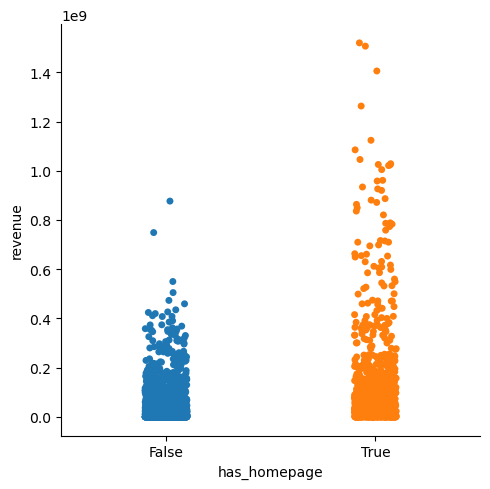

In [15]:
train["homepage"].loc[~train["homepage"].isnull()] = True
train["homepage"].loc[train["homepage"].isnull()] = False
train.rename(columns={'homepage':'has_homepage'}, inplace=True)
fig = sns.catplot(x='has_homepage', y='revenue', hue = 'has_homepage', data=train)
fig.savefig("homepage.png")
train['has_homepage'] = train['has_homepage'].astype('category').cat.codes

test["homepage"].loc[~test["homepage"].isnull()] = True
test["homepage"].loc[test["homepage"].isnull()] = False
test.rename(columns={'homepage':'has_homepage'}, inplace=True)
test['has_homepage'] = test['has_homepage'].astype('category').cat.codes


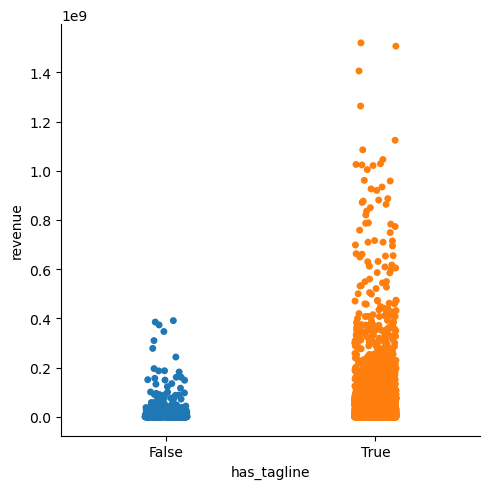

In [16]:
train["tagline"].loc[~train["tagline"].isnull()] = True
train["tagline"].loc[train["tagline"].isnull()] = False
train.rename(columns={'tagline':'has_tagline'}, inplace=True)
fig = sns.catplot(x='has_tagline', y='revenue', hue = 'has_tagline', data=train)
fig.savefig("tagline")
train['has_tagline'] =train['has_tagline'].astype('category').cat.codes

test["tagline"].loc[~test["tagline"].isnull()] = True
test["tagline"].loc[test["tagline"].isnull()] = False
test.rename(columns={'tagline':'has_tagline'}, inplace=True)
test['has_tagline'] = test['has_tagline'].astype('category').cat.codes

##### Imputing missing values with a constant (the series' mean in this case) for variables with few missing values

In [17]:
train["runtime"].fillna(value=train["runtime"].mean(), inplace=True)
test["runtime"].fillna(value=train["runtime"].mean(), inplace=True)

##### For the features we'll create using the variables at hand, we'll fill the missing values this way as well after we construct them

##### We'll deal with the missing budget values after all variables are numerical (we'll see why)

### Class imbalance

#### Original language

<Axes: xlabel='original_language', ylabel='revenue'>

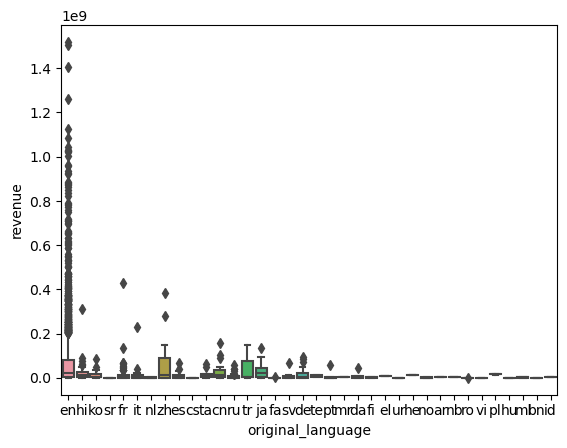

In [18]:
sns.boxplot(x=train['original_language'], y=train['revenue'])


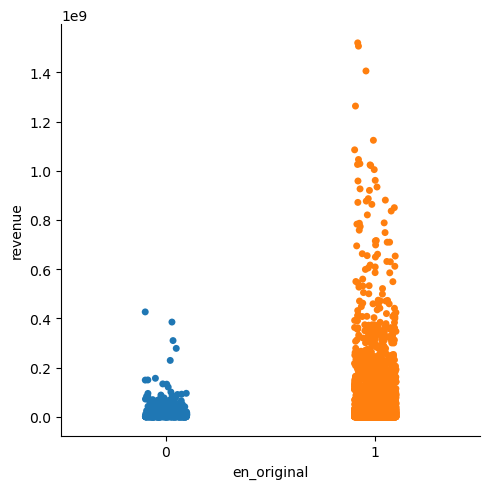

In [19]:
train["original_language"].loc[~(train["original_language"]=="en")] = 0
train["original_language"].loc[train["original_language"]=="en"] = 1
train.rename(columns={"original_language":"en_original"}, inplace=True)
sns.catplot(x="en_original", y="revenue", data=train, hue="en_original")

test["original_language"].loc[~(test["original_language"]=="en")] = 0
test["original_language"].loc[test["original_language"]=="en"] = 1
test.rename(columns={"original_language":"en_original"}, inplace=True)

#### Production country

In [20]:
train["production_countries"].fillna(method='bfill', inplace=True)
train["production_countries"] = [
    ''.join(country_str.split("'name': '")[1].split("'}")[0]) for country_str in train["production_countries"]]

test["production_countries"].fillna(method='bfill', inplace=True)
test["production_countries"] = [
    ''.join(country_str.split("'name': '")[1].split("'}")[0]) for country_str in test["production_countries"]]


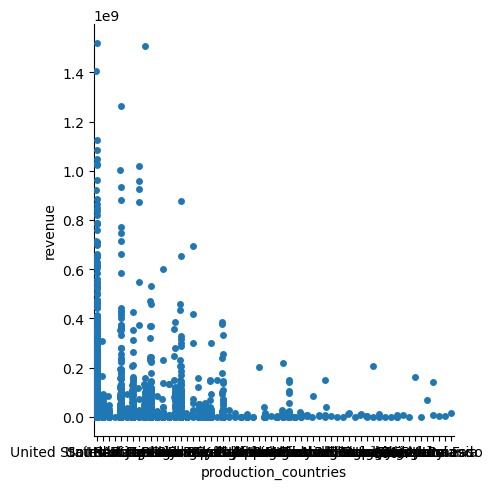

In [21]:
sns.catplot(x='production_countries', y='revenue', data=train)

In [22]:
train["production_countries"].loc[~(train["production_countries"] == "United States of America")] = 0
train["production_countries"].loc[train["production_countries"] == "United States of America"] = 1
train.rename(columns={'production_countries':'is_prod_in_us'}, inplace=True)

test["production_countries"].loc[~(test["production_countries"] == "United States of America")] = 0
test["production_countries"].loc[test["production_countries"] == "United States of America"] = 1
test.rename(columns={'production_countries':'is_prod_in_us'}, inplace=True)

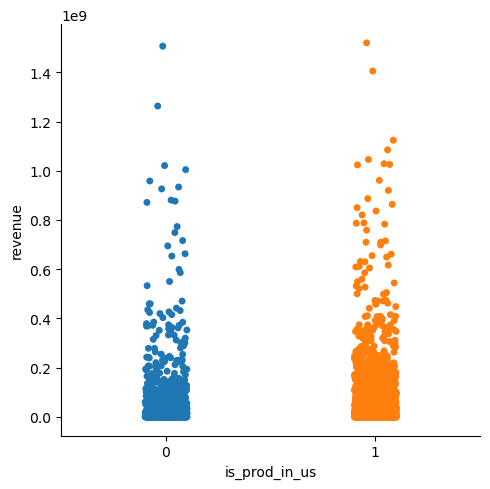

In [23]:
sns.catplot(x="is_prod_in_us", y="revenue", data=train, hue="is_prod_in_us")

### Handling non-numerical features

#### Using categorical variables

##### The genre variable is more difficult as one movie can belong to several genres

In [24]:
train['genres'] = train['genres'].apply(lambda d: d if isinstance(d, str) else [])
genres_list_train = [[''.join(s.split("'name': '")[1].split("'")[0]) for s in g.split("},")]
                if type(g)==str else [] for g in train["genres"]]
train["genres"] = genres_list_train

genres_list_test = [[''.join(s.split("'name': '")[1].split("'")[0]) for s in g.split("},")]
                if type(g)==str else [] for g in test["genres"]]
test["genres"] = genres_list_test

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

d = mlb.fit_transform(train["genres"])
c = mlb.classes_
cat_genres = pd.DataFrame(d, train.index, c)
train = pd.concat([train, cat_genres], axis = 1)
train.drop(columns="genres", inplace=True)

mlbt = MultiLabelBinarizer()
d = mlbt.fit_transform(test["genres"])
c = mlbt.classes_
cat_genres_t = pd.DataFrame(d, test.index, c)
test = pd.concat([test, cat_genres_t], axis = 1)
test.drop(columns="genres", inplace=True)

train.drop(columns=["TV Movie"], inplace=True)

##### Splitting the release date into day/month/year

In [25]:
train[['release_month', 'release_day', 'release_year']] = train['release_date'].str.split(
    '/',expand=True).applymap(lambda x: int(x) if x!=np.NaN else x)
test[['release_month', 'release_day', 'release_year']] = test['release_date'].str.split(
    '/',expand=True).applymap(lambda x: int(x) if type(x)!=float else x)
years = [1900+year if year>20 else 2000+year for year in train["release_year"]]
train["release_year"] = years
years = [1900+year if year>20 else 2000+year for year in test["release_year"]]
test["release_year"] = years
train.drop(['release_date'], axis=1, inplace=True)
test.drop(['release_date'], axis=1, inplace=True)

<Axes: xlabel='release_year', ylabel='revenue'>

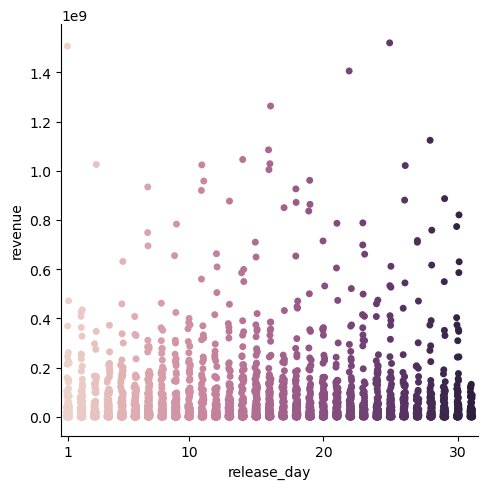

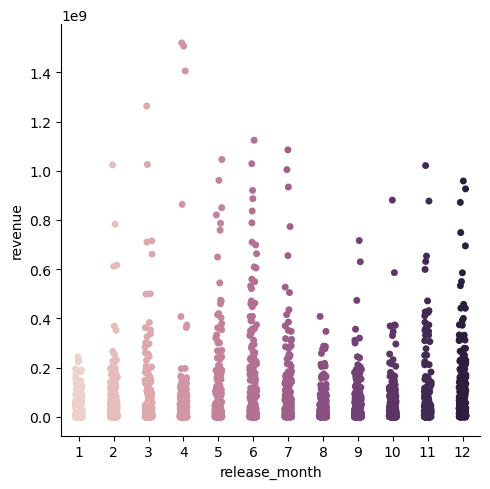

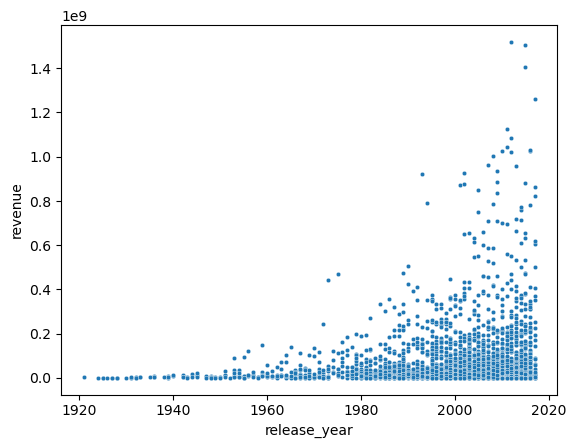

In [26]:
sns.catplot(x="release_day", y='revenue', data=train, hue="release_day")
plt.xticks([0,9,19,29])
sns.catplot(x="release_month", y='revenue', data=train, hue="release_month")
plt.figure()
sns.scatterplot(x="release_year", y='revenue', data=train, s=10)

##### Extracting useful numerical info (crew_count, cast_count, keywords) from non-numerical variables counts (crew, cast, keywords)

In [27]:
def get_dict(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

In [28]:
train["cast"].fillna(value="[]", inplace=True)
train["crew"].fillna(value="[]", inplace=True)
train["Keywords"].fillna(value="[]", inplace=True)

test["cast"].fillna(value="[]", inplace=True)
test["crew"].fillna(value="[]", inplace=True)
test["Keywords"].fillna(value="[]", inplace=True)

train["cast"] = [len(eval(c)) if len(eval(c))>0 else np.nan for c in train["cast"]]
train["crew"] = [len(eval(c)) if len(eval(c))>0 else np.nan for c in train["crew"]]
train["Keywords"] = [len(eval(c)) if len(eval(c))>0 else np.nan for c in train["Keywords"]]

test["cast"] = [len(eval(c)) if len(eval(c))>0 else np.nan for c in test["cast"]]
test["crew"] = [len(eval(c)) if len(eval(c))>0 else np.nan for c in test["crew"]]
test["Keywords"] = [len(eval(c)) if len(eval(c))>0 else np.nan for c in test["Keywords"]]

train.rename(columns={'cast':'cast_count'}, inplace=True)
train.rename(columns={'crew':'crew_count'}, inplace=True)
train.rename(columns={'Keywords':'Keywords_count'}, inplace=True)

test.rename(columns={'cast':'cast_count'}, inplace=True)
test.rename(columns={'crew':'crew_count'}, inplace=True)
test.rename(columns={'Keywords':'Keywords_count'}, inplace=True)


In [29]:
train["cast_count"].fillna(value=train["cast_count"].mean(), inplace=True)
train["crew_count"].fillna(value=train["crew_count"].mean(), inplace=True)
train["Keywords_count"].fillna(value=train["crew_count"].mean(), inplace=True)

test["cast_count"].fillna(value=test["cast_count"].mean(), inplace=True)
test["crew_count"].fillna(value=test["crew_count"].mean(), inplace=True)
test["Keywords_count"].fillna(value=test["crew_count"].mean(), inplace=True)

<Axes: xlabel='Keywords_count', ylabel='revenue'>

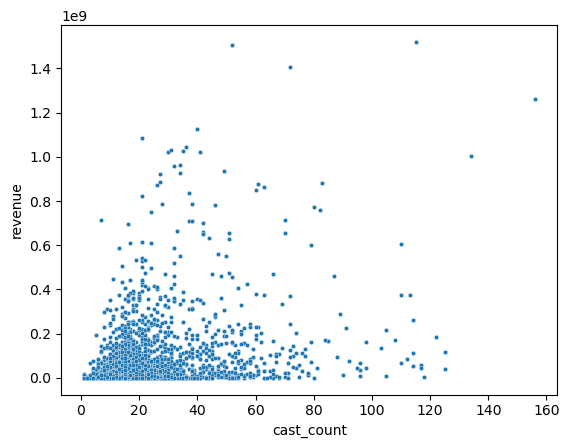

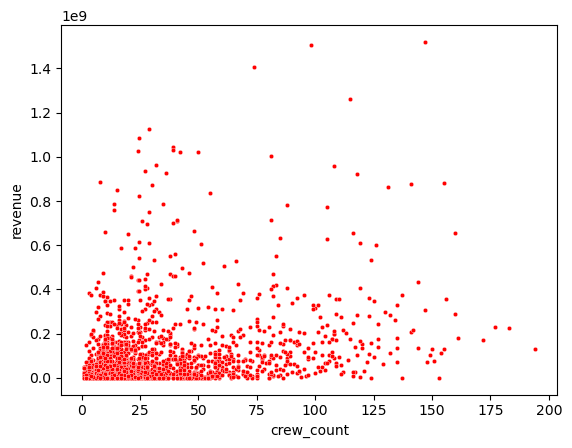

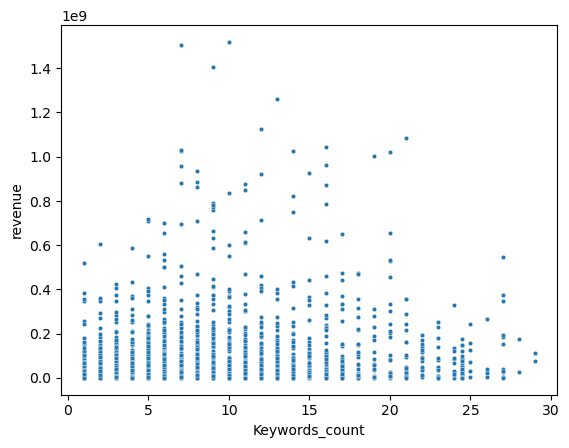

In [30]:
plt.figure()
sns.scatterplot(x="cast_count", y="revenue",data=train, s=10)
plt.figure()
sns.scatterplot(x="crew_count", y="revenue",data=train, color='red',s=10)
plt.figure()
sns.scatterplot(x="Keywords_count", y="revenue",data=train[train["Keywords_count"] < 30], s=10)

#### Spoken languages

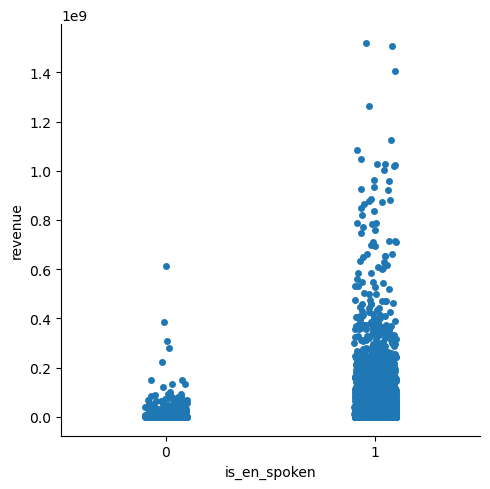

In [31]:
def get_dict(spoken_language):
    try:
        s = eval(spoken_language)
    except:
        s = {}
    return s

train["spoken_languages"].fillna(value="[]", inplace=True)
test["spoken_languages"].fillna(value="[]", inplace=True)

train["spoken_languages"] = [({'iso_639_1': 'en', 'name': 'English'} in get_dict(l)) for l in train["spoken_languages"]]
test["spoken_languages"] = [({'iso_639_1': 'en', 'name': 'English'} in get_dict(l)) for l in test["spoken_languages"]]

train["spoken_languages"].loc[train["spoken_languages"]==True] = 1
train["spoken_languages"].loc[train["spoken_languages"]==False] = 0
train.rename(columns={'spoken_languages':'is_en_spoken'}, inplace=True)

test["spoken_languages"].loc[test["spoken_languages"]==True] = 1
test["spoken_languages"].loc[test["spoken_languages"]==False] = 0
test.rename(columns={'spoken_languages':'is_en_spoken'}, inplace=True)

sns.catplot(x="is_en_spoken", y="revenue", data=train)

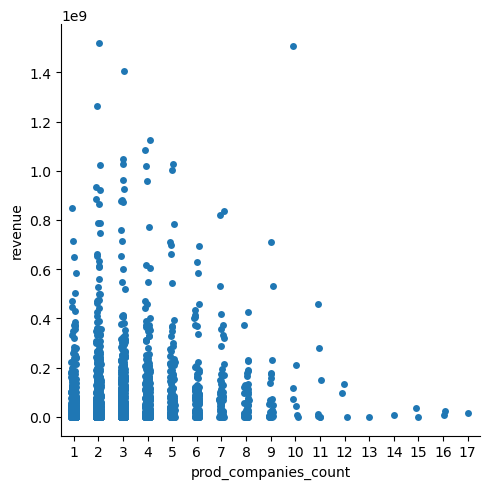

In [32]:
train["production_companies"].fillna(value="[]", inplace=True)
train["production_companies"] = [len(get_dict(c)) for c in train["production_companies"]]
train.rename(columns={'production_companies':'prod_companies_count'}, inplace=True)

test["production_companies"].fillna(value="[]", inplace=True)
test["production_companies"] = [len(get_dict(c)) for c in test["production_companies"]]
test.rename(columns={'production_companies':'prod_companies_count'}, inplace=True)

sns.catplot(x="prod_companies_count", y="revenue", data=train[train["prod_companies_count"] != 0])

#### Dealing with the budget missing values

In [33]:
train["budget"].loc[train["budget"]==0] = np.NaN
test["budget"].loc[test["budget"]==0] = np.NaN

<Axes: title={'center': 'Histogram of budget in test with missing values set to budget mean'}, xlabel='budget', ylabel='Probability'>

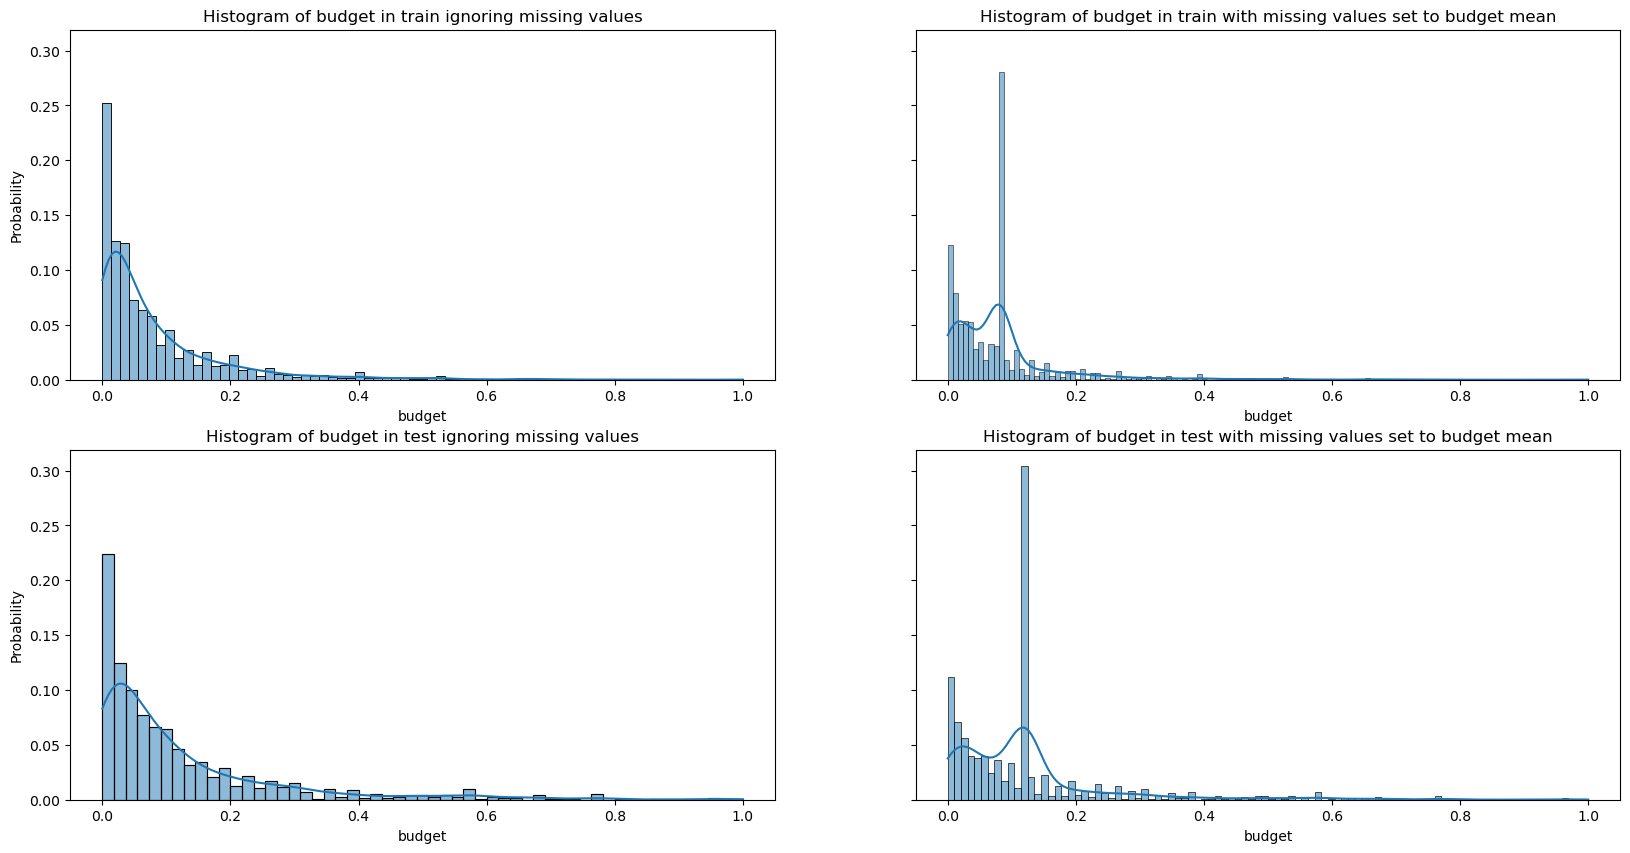

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

imputer_train = KNNImputer(n_neighbors=5)
imputer_test = KNNImputer(n_neighbors=5)
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

train_norm = pd.DataFrame(scaler_train.fit_transform(train), columns = train.columns)
test_norm = pd.DataFrame(scaler_test.fit_transform(test), columns = test.columns)

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(20, 10), sharey=True)

sns.histplot(ax=ax1[0], x="budget", data=train_norm, kde=True, stat="probability")
sns.histplot(ax=ax2[0], x="budget", data=test_norm, kde=True, stat="probability")
ax1[0].set_title("Histogram of budget in train ignoring missing values")
ax2[0].set_title("Histogram of budget in test ignoring missing values")
train_norm["budget"].fillna(train_norm["budget"].mean(), inplace=True)
test_norm["budget"].fillna(test_norm["budget"].mean(), inplace=True)
ax1[1].set_title("Histogram of budget in train with missing values set to budget mean")
ax2[1].set_title("Histogram of budget in test with missing values set to budget mean")
sns.histplot(ax=ax1[1], x="budget", data=train_norm, kde=True, stat="probability")
sns.histplot(ax=ax2[1], x="budget", data=test_norm, kde=True, stat="probability")


Text(0.5, 1.0, 'Histogram of budget in test with KNN imputation')

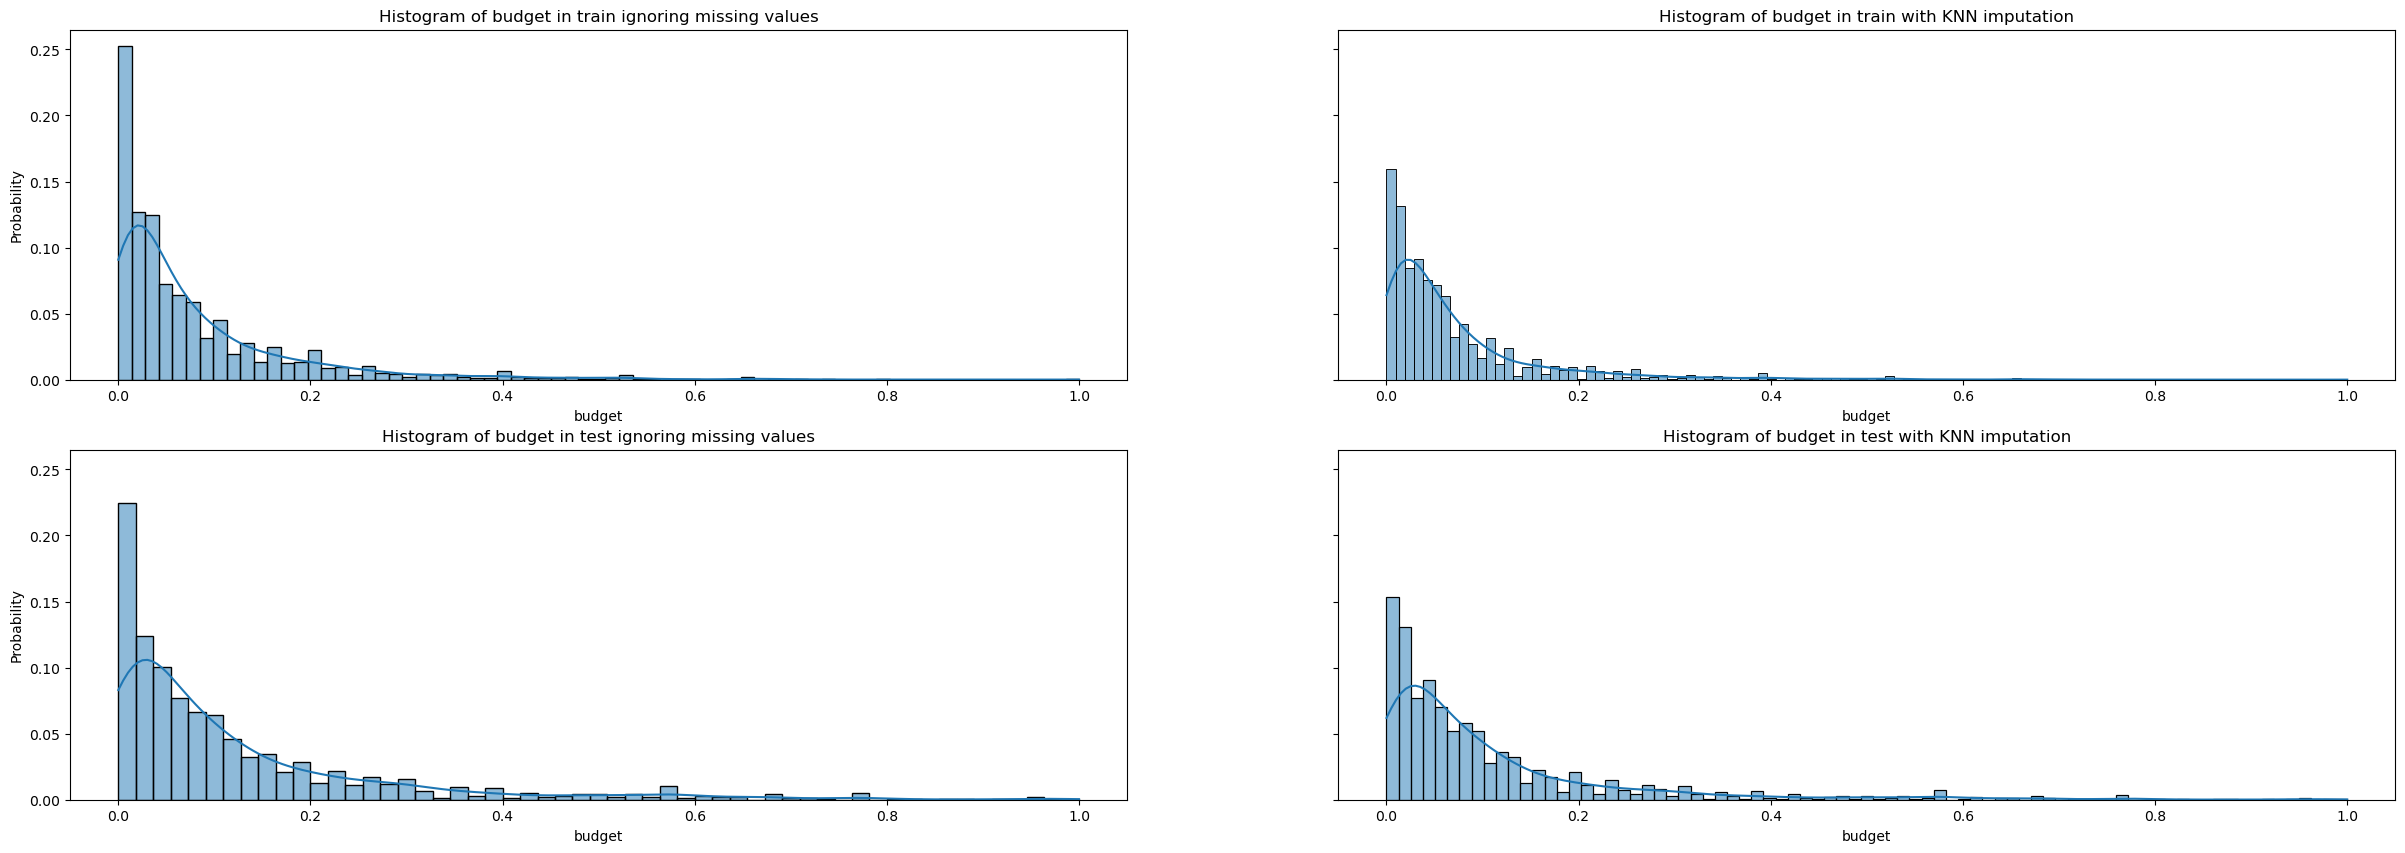

In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

imputer_train = KNNImputer(n_neighbors=5)
imputer_test = KNNImputer(n_neighbors=5)
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

train_norm = pd.DataFrame(scaler_train.fit_transform(train), columns = train.columns)
test_norm = pd.DataFrame(scaler_test.fit_transform(test), columns = test.columns)

fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(30, 10), sharey=True)

sns.histplot(ax=ax1[0], x="budget", data=train_norm, kde=True, stat="probability")
sns.histplot(ax=ax2[0], x="budget", data=test_norm, kde=True, stat="probability")
ax1[0].set_title("Histogram of budget in train ignoring missing values")
ax2[0].set_title("Histogram of budget in test ignoring missing values")

train_norm = pd.DataFrame(imputer_train.fit_transform(train_norm),columns = train_norm.columns)
test_norm = pd.DataFrame(imputer_test.fit_transform(test_norm),columns = test_norm.columns)

sns.histplot(ax=ax1[1], x="budget", data=train_norm, kde=True, stat="probability")
sns.histplot(ax=ax2[1], x="budget", data=test_norm, kde=True, stat="probability")
ax1[1].set_title("Histogram of budget in train with KNN imputation")
ax2[1].set_title("Histogram of budget in test with KNN imputation")

## 2) Regression models

#### Splitting the training dataset into train and test

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
import math

### Evaluating performance on the engineered features

#### Splitting the dataset between train and validation ("test" here)

In [ ]:
X = train_norm.drop("revenue", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

#### Training the kNN model and determining k_opt

In [ ]:
modelknn = KNeighborsRegressor()
RMSLEknn = []
for k in range(1, 20):
    modelknn = KNeighborsRegressor(n_neighbors=k)
    modelknn.fit(X_train,y_train)
    y_pred=modelknn.predict(X_test)
    RMSLEknn.append(math.sqrt(mean_squared_log_error(y_true=y_test,y_pred=y_pred)))
ind_k_opt = np.array(RMSLEknn).argmin()

RMSLE_forest = []

#### Training the random forest and determining n_opt

In [ ]:
for n in [50,100,150,200,250]:
    model_forest = RandomForestRegressor(n_estimators=n)
    model_forest.fit(X_train,y_train)
    y_pred=model_forest.predict(X_test)
    y_pred[y_pred<0]=0
    RMSLE_forest.append(math.sqrt(mean_squared_log_error(y_true=y_test,y_pred=y_pred)))
ind_n_opt = np.array(RMSLE_forest).argmin()

#### Linear regression model

In [ ]:
model_linear = LinearRegression()
model_linear.fit(X_train,y_train)
y_pred=model_linear.predict(X_test)
y_pred[y_pred<0]=0
RMSLE_linear = math.sqrt(mean_squared_log_error(y_true=y_test,y_pred=y_pred))

      Modelling Name     RMSLE
0  Linear Regression  6.812072
1                KNN  2.973179
2      Random Forest  2.740039


#### Performance summary

In [ ]:
performances = pd.DataFrame({'Modelling Name':["Linear Regression", "KNN", "Random Forest"],
                             "RMSLE":[RMSLE_linear, RMSLEknn[ind_k_opt], RMSLE_forest[ind_n_opt]]})
print(performances)

In [ ]:
print("Optimal number of neighbours for knn : " + str(ind_k_opt+1))
print("Optimal number of estimators for Random Forest regressor : " + str(250))

Optimal number of neighbours for knn : 3
Optimal number of estimators for Random Forest regressor : 250


#### Export the predicted dataset to csv

In [ ]:
model = RandomForestRegressor(n_estimators=250)
model.fit(X,y)
Prediction = model.predict(test_norm)
Predictions = pd.DataFrame({"id":test_ids,"revenue":Prediction})
Predictions.to_csv("submission.csv",index=False)